# Mock for Song

## Notes

We work in distances of **Mpc/h** and masses of **Msun**.

We want to take an N-body simulation (currently MDPL but could be anything) and put galaxies in it in a way that creates a universe consistent with HSC observations. We are building an HSC mock catalog.

To do this we use the functional form which relates stellar mass to halo mass from [Behroozi2010](https://arxiv.org/pdf/1001.0015.pdf). As this is a mean relation we will also need a scatter term which we allow to vary linearly with log(halo mass). Finally, we get a good starting fit for the Behroozi functional form from [Leauthaud2012](https://arxiv.org/pdf/1104.0928.pdf) and for the scatter term from CB in prep.

As this functional form relates stellar mass - halo mass we initially generated stellar masses using various halo masses (Mvir, Mpeak). We were able to fit the SMF but clustering was low. After talking to Peter, this is apparently known and we should instead be populating stellar mass using Vmax@Mpeak. See [appendix A](./appendix.ipynb) for a description of how we get the initial coordinates.

With these initial fits we run an optimizer that takes into account both the SM and the clustering. We find that we can match the SMF well (all bins within the error bars) but have low clustering (HSC is 18.5 +/- 1.7, mock is 14 +/- 0.2). I don't really know how to evaluate whether this is good enough.

### How to run this

* If you want to re-run the opimizer, just run everything though  (takes O(hours)).
* If you just want to run the best fit model, run everything except the optimizer (takes O(1 minute)).

## Import etc...

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.interpolate, scipy.optimize
import emcee

import data as d
import likelihood as l
import plots as p
import clustering as c

import smhm_fit
from get_sm_for_sim import get_sm_for_sim, get_smf

from Corrfunc.utils import convert_3d_counts_to_cf

%run ~/.jupyter/config.ipy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load data + initial config

In [2]:
# For the clustering, we look around objects with mass in the "cen_cuts" range and 
# count objects in the "sat_cuts" range
cen_cuts = (11.65, 12.5)
sat_cuts = (11.55, 11.65)

# See the appendix A for how we got these starting params
b_params = [2.4, 10.91, 0.6, 0.2, 0.2]
s_params = [-0.1, 0.5]
params = b_params + s_params
x_field = "Vmax@Mpeak"

# To speed things up we store a previous best_fit
best_fit = params = [ 2.38790706, 10.95734763,  0.59796762,  0.20280535,  0.22251674, -0.09911975,  0.51084631]

In [3]:
# The simulation data
sim_data, sim_size = d.load_mdpl()

# The observational data that we fit to
hsc_gals = d.load_hsc_gals()
obs_clust, obs_clust_err = c.compute_hsc_clustering(hsc_gals, cen_cuts, sat_cuts)
obs_smf = d.load_smf()

/home/christopher/.virtualenvs/greg/lib/python3.6/site-packages/Corrfunc/mocks/DDrppi_mocks.py:348: UserWarning: One or more input array has non-native endianness!  A copy will be made with the correct endianness.
  warn('One or more input array has non-native endianness!  A copy will be made with the correct endianness.')


# Find bestfit to SMF with optimizer

In [ ]:
res = scipy.optimize.minimize(
    l.compute_chi2_n,
    x0 = params,
    args=(sim_data, obs_smf, obs_clust, obs_clust_err, sim_size, cen_cuts, sat_cuts, x_field, 1),
    method="Nelder-Mead",
    tol=1,
)
assert res.success == True
best_fit = res.x

[ 2.38722978 10.95809255  0.59466785  0.20324341  0.21333298 -0.09899878  0.51040192]
8.16262732380987
[ 2.50659127 10.95809255  0.59466785  0.20324341  0.21333298 -0.09899878  0.51040192]
177.61508386886402
[ 2.38722978 11.50599718  0.59466785  0.20324341  0.21333298 -0.09899878  0.51040192]
714845.7838454088
[ 2.38722978 10.95809255  0.62440124  0.20324341  0.21333298 -0.09899878  0.51040192]
8.301840116333745
[ 2.38722978 10.95809255  0.59466785  0.21340558  0.21333298 -0.09899878  0.51040192]
9.007539907312038
[ 2.38722978 10.95809255  0.59466785  0.20324341  0.22399963 -0.09899878  0.51040192]
6.895124437791847
[ 2.38722978 10.95809255  0.59466785  0.20324341  0.21333298 -0.10394872  0.51040192]
16.608081106244434
[ 2.38722978 10.95809255  0.59466785  0.20324341  0.21333298 -0.09899878  0.53592202]
126.09893977658444
[ 2.42133306 10.41018792  0.60316311  0.20614689  0.21638059 -0.10041305  0.51769338]
523.7994125232723
[ 2.41280724 10.68414024  0.60103929  0.20542102  0.21561869 -

7.161332526551161
[ 2.38736958 10.95806942  0.59786594  0.20304478  0.22183053 -0.09906232  0.51042039]
8.133101377119505
[ 2.38800027 10.95740727  0.59669081  0.20216849  0.22332483 -0.09914018  0.51079157]
7.281142226192912
[ 2.38817973 10.95729985  0.59802259  0.20291052  0.22253646 -0.0991876   0.51102075]
9.730932853753052
[ 2.38782848 10.95730438  0.59817641  0.20202643  0.22259164 -0.09914996  0.51103055]
8.50337159523119
[ 2.3875878  10.95769226  0.59872372  0.2023658   0.22278798 -0.09907721  0.51018875]
8.491998651319165
[ 2.38756842 10.95772009  0.59631773  0.20302438  0.22325818 -0.09905926  0.51062412]
8.148977236705122
[ 2.38783408 10.95764105  0.59582265  0.20275749  0.2224003  -0.09911784  0.51071861]
7.257507395158443
[ 2.38803428 10.95740939  0.59764476  0.20254081  0.22261083 -0.09910728  0.51087045]
7.2243549782740955
[ 2.38805878 10.95726709  0.59713336  0.20234087  0.22316983 -0.09914294  0.5108808 ]
8.06193571476739
[ 2.38748281 10.9576664   0.59677348  0.2021926

6.345960381807893
[ 2.38791051 10.9573532   0.59786054  0.20282602  0.22252498 -0.09911853  0.51085054]
8.703778151262677
[ 2.38791619 10.95734324  0.59789569  0.20279238  0.2225276  -0.09912114  0.51086193]
7.565789156230744
[ 2.38791241 10.95734988  0.59787226  0.20281481  0.22252585 -0.0991194   0.51085434]
7.6225015569177685
[ 2.38791524 10.9573449   0.59788983  0.20279799  0.22252716 -0.0991207   0.51086003]
7.053885885603616
[ 2.38790486 10.95735512  0.59786801  0.20281482  0.22254359 -0.09911798  0.51084126]
7.61754291806568
[ 2.3879176  10.95734343  0.59789027  0.20279891  0.22252117 -0.0991211   0.51086408]
7.920489960972956
[ 2.38790631 10.95734859  0.59790402  0.20280187  0.22252307 -0.09911946  0.51085531]
7.528272828129544
[ 2.38791601 10.95734594  0.59788641  0.20281732  0.22252915 -0.0991202   0.51085584]
8.386793291559734
[ 2.3879133  10.95734679  0.59792171  0.20280598  0.22252247 -0.09912012  0.5108534 ]
7.63060921169856
[ 2.38790788 10.95734819  0.59794494  0.2027989

7.880135156996742
[ 2.38790719 10.95734761  0.59796629  0.20280556  0.22251686 -0.09911976  0.51084652]
7.045431176167401
[ 2.3879072  10.95734761  0.59796704  0.20280559  0.22251685 -0.09911975  0.51084636]
7.581266594899377
[ 2.38790711 10.95734763  0.59796683  0.20280541  0.22251678 -0.09911975  0.51084644]
7.763291240392972
[ 2.38790712 10.95734762  0.5979667   0.20280552  0.22251691 -0.09911974  0.51084642]
8.39520916700657
[ 2.3879071  10.95734764  0.59796671  0.20280546  0.22251685 -0.09911975  0.5108464 ]
7.60758772676366
[ 2.38790712 10.95734764  0.59796679  0.20280542  0.22251694 -0.09911974  0.51084634]
7.410064543743101
[ 2.38790715 10.95734763  0.59796707  0.20280538  0.22251676 -0.09911976  0.51084637]
8.862307255931023
[ 2.38790713 10.95734762  0.59796679  0.20280549  0.22251687 -0.09911975  0.51084641]
9.847528702010308
[ 2.38790712 10.95734762  0.59796696  0.20280545  0.2225168  -0.09911975  0.51084642]
8.281349819071874
[ 2.38790709 10.95734763  0.59796721  0.20280539

7.643023626482796
[ 2.38790706 10.95734763  0.5979676   0.20280536  0.22251674 -0.09911975  0.51084632]
7.387574120780124
[ 2.38790706 10.95734763  0.5979676   0.20280535  0.22251674 -0.09911975  0.51084632]
7.7474720112348034
[ 2.38790706 10.95734763  0.5979676   0.20280535  0.22251674 -0.09911975  0.51084632]
8.840391904695123
[ 2.38790706 10.95734763  0.59796761  0.20280535  0.22251674 -0.09911975  0.51084631]
7.220912457966945
[ 2.38790706 10.95734763  0.59796761  0.20280535  0.22251674 -0.09911975  0.51084632]
8.401773998942202
[ 2.38790706 10.95734763  0.59796761  0.20280535  0.22251674 -0.09911975  0.51084631]
7.59555991052288
[ 2.38790706 10.95734763  0.59796761  0.20280535  0.22251674 -0.09911975  0.51084632]
7.518388448598965
[ 2.38790706 10.95734763  0.59796761  0.20280535  0.22251674 -0.09911975  0.51084631]
8.227461774226299
[ 2.38790706 10.95734763  0.59796762  0.20280535  0.22251674 -0.09911975  0.51084631]
7.421437569453346
[ 2.38790706 10.95734763  0.59796762  0.202805

# Build bestfit model and compare to observations

In [4]:
log_stellar_masses = get_sm_for_sim(sim_data, best_fit[:5], best_fit[5:], x_field)

18.402036701422663 1.6810768947308645
14.7239305141483 0.23413500831791723


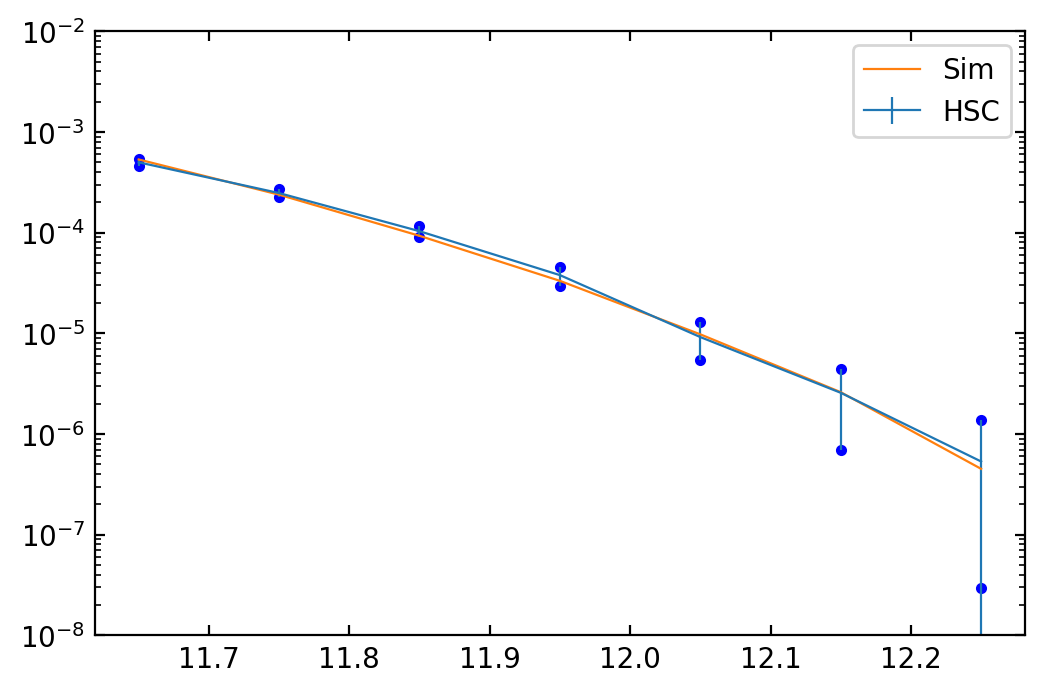

In [7]:
ax = p.plot_smfs(sim_data, obs_smf, best_fit[:5], best_fit[5:], sim_size, x_field)
ax.set(ylim=(1e-8, 1e-2));

sim_clust, sim_clust_err  = c.compute_sim_clustering(sim_data, sim_size, log_stellar_masses, cen_cuts, sat_cuts)
print(obs_clust, obs_clust_err)
print(sim_clust, sim_clust_err)